## Exploration_13_GAN

1. 데이터 준비
2. 모델 구현
3. 모델 학습 & 결과 확인
4. 회고

### 1. 데이터 준비

In [159]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


#### cifar10 데이터 불러오기

In [160]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [161]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


#### 정규화

In [162]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### Data reshaping : 3채널(RGB) 추가

In [163]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32') # 32x32x3(RGB) 형태로 변환
train_x.shape

(50000, 32, 32, 3)

#### 이미지 확인

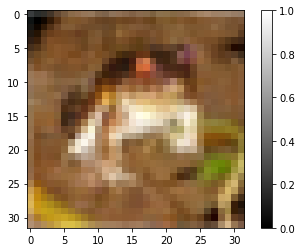

In [164]:
# 정규화 [-1, 1] 첫번재 이미지
tmp_train_x = (train_x+1)*0.5 # [0, 1] 범위로 train data 조절
plt.imshow(tmp_train_x[0].reshape(32, 32, 3), cmap='gray')
plt.colorbar()
plt.show()

* [-1, 1] 범위로 정규화를 시켰지면 imshow 에서 RGB data를 나타내는 최소 값이 0이기 때문에 [0, 1] 범위로 표시 된다는 경고 메세지가 출력된다.
* 따라서 값을 이 범위로 맞춰주기 위해 'train_x = (train_x+1)x0.5' 계산식을 추가 해 준다

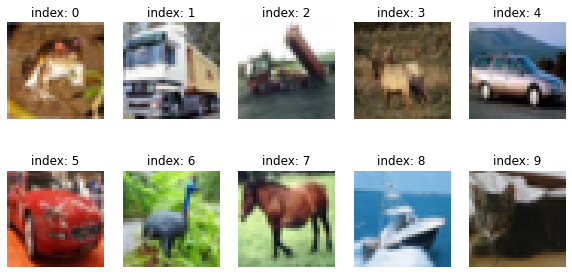

In [165]:
# 정규화 [-1, 1] 여러 이미지
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(tmp_train_x[i].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

* 정상적으로 CIFAR10 이미지들이 출력되는 것을 볼 수 있다.

#### 변수 설정

In [166]:
BUFFER_SIZE = 50000 # 이미지 총 개수
BATCH_SIZE = 256

* 추후에 사용 될 변수를 미리 설정한다.

#### 데이터셋 설정

In [167]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

* 지정한 BATCH_SIZE 만큼 씩 학습이 일어나도록 설정한다.

### 2. 모델 구현

#### 생성자(Generator) 모델 구현

In [119]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

* 우리가 사용하는 이미지에 맞게 8x8x256의 형태로 초기값을 입력 해 준다.

In [120]:
generator = make_generator_model()

generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 8, 8, 128)       

* 최종 출력 값이 (32, 32, 3)의 형태를 가진다

#### noise 생성

In [173]:
noise = tf.random.normal([1, 100]) # 랜덤한 값을 가진 noise vector를 만든다.

In [174]:
generated_image = generator(noise, training=False) # noise 이미지 생성
generated_image.shape

TensorShape([1, 32, 32, 3])

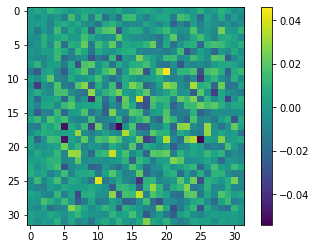

In [175]:
plt.imshow(generated_image[0,:,:,0]) # noise 이미지 출력
plt.colorbar()
plt.show()

* 랜덤한 값에 대한 노이즈 이미지가 만들어진 것을 출력을 통해 확인 할 수 있다.
* 당연하게 랜덤 값을 base로 만들어졌기 때문에 아무 의미없는 이미지가 생성된다.
* 이렇게 만들어진 noise는 추후에 training 단계에서 사용 된다.

#### 판별자(Discriminator) 모델 구현

In [124]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 3: Flatten Layer
    model.add(layers.Flatten())

    # 4: Dense Layer
    model.add(layers.Dense(1))

    return model

* 32x32x3으로 input_shape을 바꿔주고 만들어진 모델을 확인 해 본다.

In [125]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)            

In [176]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50032926]], dtype=float32)>

* 모델을 noise를 통해 test 해 본 결과 정상적으로 1x1 의 tensor가 만들어진 것을 알 수 있고, 따라서 모델이 정상 작동 할 것이라 예상 할 수 있다.

#### 손실함수(loss function) 설정

In [177]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* GAN에서는 손실함수로 cross entropy를 사용한다.
* 그 중 특히 discriminator 는 진짜, 가짜의 두 개를 구분하는 것이기 때문에 binary cross entropy 를 사용한다.

In [178]:
# Generator 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

* fake image를 real image로 판단할 수록 결과값은 1 에 가까워지고 loss 값은 0 에 가까워 지게 된다.
* 따라서 fake_output 의 결과를 1 과 비교를 해서 cross entropy를 구하는 방식으로 진행 된다.

In [179]:
# Discriminator 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* Discriminator는 real image를 1로 fake image를 0으로 판단 하는 것을 목표로 한다.
* 따라서 두 가지 상황에 대한 loss 값을 각각 구한뒤에 결과값을 합쳐서 최종 loss 값을 결정한다.

#### Accuracy 함수 설정

In [180]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

* loss 와 마찬가지로 두 가지 경우에 따른 accuracy 값을 구한다.
* 만약 어느 쪽이든 accuracy 값이 1에 가깝게 나온다면 이미지를 정확하게 구분 해 내고 있다는 뜻이 된다.
* 즉 가짜는 가짜로, 진짜는 진짜로 구분을 한다는 말이되고 따라서 가짜를 진짜처럼 만들고자 하는 우리의 목적에 부합하게 작동하지 않고 있다는 뜻이 된다.
* 따라서 두 accuracy 값이 1이 아닌 0.5에 가까워 질 수록 우리가 원하는 결과에 가까워 진다고 볼 수 있다.

#### 최적화 함수(optimizer) 구현

In [131]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

* Generator, discriminator 에 대해 각각 optimzier를 설정 해 준다.

#### Noise 세부 설정

In [181]:
noise_dim = 100
num_examples_to_generate = 16 # 출력 이미지 개수

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

* 동일한 noise가 계속해서 만들어지도록 seed를 설정 해 둔다.

#### Training (한 단계 학습) 함수 구현

In [182]:
@tf.function # 데코레이터 : numpy array 를 tensorflow 형태로 변경
def train_step(images):  # 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  # generated_images 생성

        #discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    # gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # loss, accuracy 리턴

* 앞서 작성 된 함수들을 이용하여 loss, accuracy 값을 구한 뒤 리턴한다.
* 데코레이터 (@tf.function)를 사용하면 계산 된 데이터의 타입을 tensorflow 형태로 만들어지게 되고, 이는 결과값을 이용한 그래프를 그리는 작업을 매우 수월하게 해준다고한다.

#### 생성된 이미지 확인 및 저장을 위한 함수

In [183]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions = (predictions+1)*0.5 # 생성 이미지의 
    fig = plt.figure(figsize=(12, 12))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

* 지정된 루트에 16개 씩 이미지를 저장한다.

#### Training history 출력 함수

In [184]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

* gen_loss, disc_loss, real_accuracy, fake_accuracy의 정보가 dictionary 의 형태로 history에 저장 되어있고, 이 정보를 받아 출력하는 함수이다.

#### 학습의 중간과정을 저장하는 함수

In [185]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

* 오랜시간 학습이 이뤄지는 만큼 중간단계를 저장하는 함수가 필요하다.

#### 최종 training 함수 구현

In [186]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset): # 전체 데이터에서
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch) # 한 단계씩 학습을 진행
            history['gen_loss'].append(gen_loss) # 각 loss, accuracy를 구하고
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 10 == 0: # 10번째 마다 아래 정보를 출력
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))   

        if (epoch + 1) % save_every == 0: # save_every 마다 저장
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [187]:
save_every = 10
EPOCHS = 50
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

* GPU 가 빠르기 때문에 가능하면 GPU를 사용한다.

### 3. 모델 학습 & 결과 확인

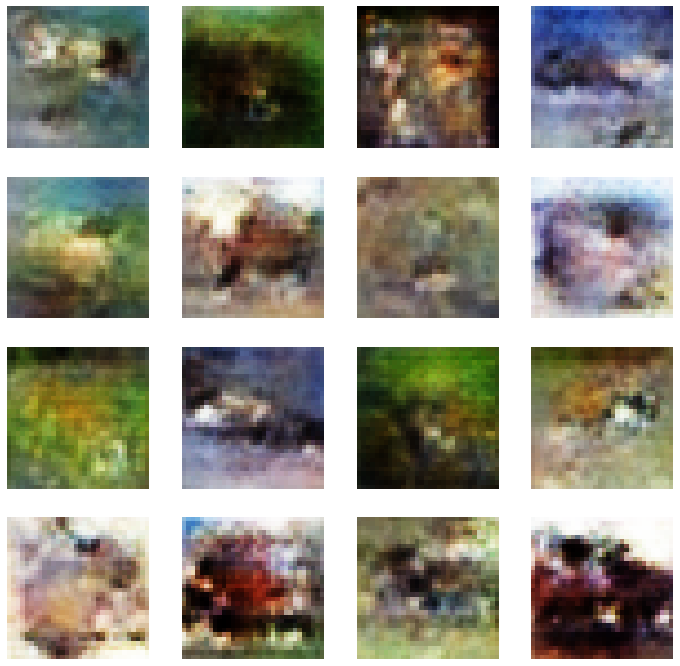

Time for training : 4140 sec


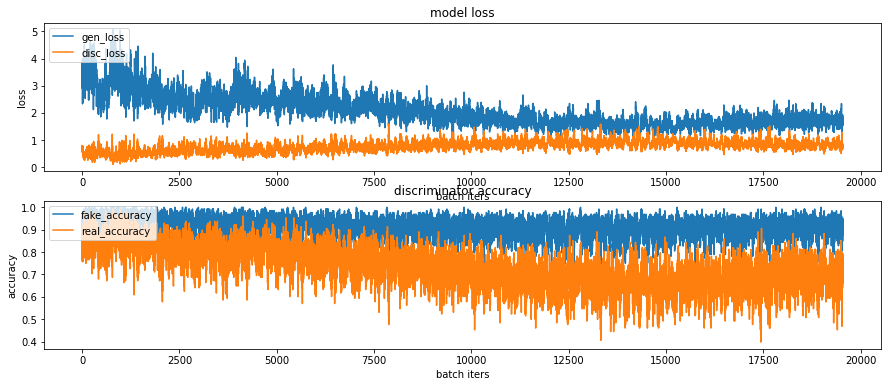

CPU times: user 38min 6s, sys: 1min 28s, total: 39min 34s
Wall time: 1h 9min 1s


In [43]:
# BATCH_SIZE : 128
%%time
train(train_dataset, EPOCHS, save_every)

* Epochs 50, batch_size 128 일 때의 결과이다.
* 결과물을 판단할 수 있을 정도로 이미지가 명확하지 못하다.
* 그리고 그래프 상으로 gen_loss 값이 1에 수렴하고 있지 못하고, real_accuracy는 감소하고 있지만 fake_accuracy 값이 계속 0.8~1.0 사이에서 머무르고 있다. 우리가 원하는 값은 0.5이므로 결론적으로 학습이 제대로 이뤄지지 않고 있다고 할 수 있다.
* 따라서 추가적으로 epochs 및 batch_size를 재설정하여 실행해본 뒤 결과를 비교해 보기로 한다.

#### 모델 재학습 - BATCH:256, EPOCHS:100

In [140]:
# BATCH_SIZE = 256
EPOCHS = 100 # epochs 50 -> 100
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

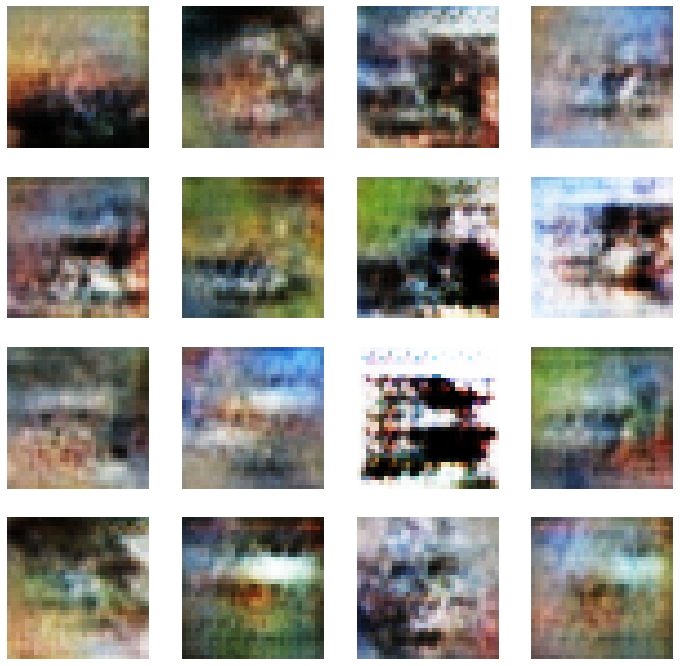

Time for training : 4597 sec


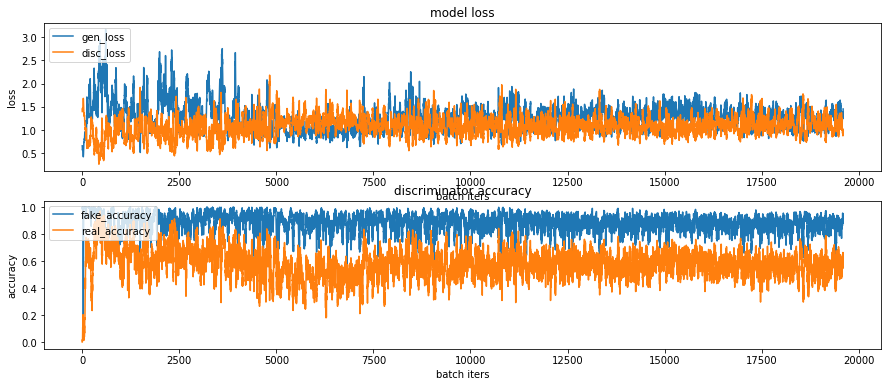

CPU times: user 1h 19min 28s, sys: 1min 48s, total: 1h 21min 17s
Wall time: 1h 16min 39s


In [141]:
%%time
train(train_dataset, EPOCHS, save_every)

* 위 결과와 현재 결과를 비교해 보면 loss 값은 1로 수렴하고 있지만, fake_accuracy 값은 여전히 0.8~1.0 사이에 머물고 있다. 따라서 다른 방법이 필요해 보인다.
* 이미지 상으로도 (4, 3) 위치의 그림은 약간 동물(일본 원숭이 정면얼굴)처럼 보이긴 하지만 그 외의 이미지들은 여전히 불명확하며, 앞선 테스트 결과와 비슷한 수준에서 더 나아지지 않은 것을 알 수 있다.
* 하지만 여러 테스트를 해보면서 느낀바로는 Batch_size는 128이 256 보다는 좀 더 선명한 이미지를 만들어 내는 것 처럼 보였다. 하지만 그만큼 시간이 오래 걸리기 때문에 일단 256으로 설정하고 다른 조건들을 이용해 결과값을 상향 시킨 뒤에 마지막으로 128로 낮춰서 진행 해 볼 생각이다.

#### 모델 재학습 2 - layer 추가, 각종 parameter 값 조절
- 첫 번째로 batch_size, epochs의 조절을 통해 성능향상 여부를 확인 해 보았다. Epochs는 50, 100, 200의 총 3단계로 테스트를 진행 해 봤었는데 100 이후로는 큰 차이를 느낄 수 없었다. 따라서 이 외에 다른 몇가지 방법들을 추가하여 테스트를 해 보고 그 결과를 비교해 보기로 했다.
1. Generator, discriminator에서 layer를 하나 더 추가 한다. 이로 인해 이미지 크기 전환의 단계가 generator에서는 8->16 에서 4->8->16으로, discriminator에서는 8->1 에서 8->4->1 로 변경되며 조금 더 디테일한 학습이 이뤄질 것이라 기대한다. Layer 가 추가 됨에 따라 strides 값도 조금씩 변경 시킨다.
2. Generator, discriminator의 LeakyReLu의 parameter를 조절 해 본다.
3. Dense의 activation function을 'sigmoid'로 설정 해 준다.
4. 마지막으로 optimizer의  parameter 값을 조절한다.
- 시간상 모든 parameter 들을 직접 테스트 해 볼 수는 없기 때문에 아래 참고사이트의 값들을 가져와 테스트를 진행 해 본다.
- Ref_1 : https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
- Ref_2 : https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- Ref_3 : https://www.youtube.com/watch?v=EYrt7fGyA08&ab_channel=HenryAILabs

#### Generator 재 설정 (변경 사항은 주석으로 작성)

In [168]:
# Generator 재 설정
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Dense layer :
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2)) # alpha 값을 0.2로 설정

    # 2: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
#     # 3: Conv2DTranspose layer 추가 -> 테스트 결과 오히려 학습에 방해가 되었으므로 삭제
#     model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=0.2))
    
    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # 5: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

* layer를 하나 추가하고 각종 파라미터를 설정하여 학습효율을 높이고자 했다. parameter를 설정한 것은 보다 효율적인 학습에 영향을 줄 것이라 생각이 되지만 layer를 추가한 것에 대해서는 아직 확신이 없으므로 결과를 확인 해 봐야 알 것 같다.

In [169]:
# Generator 모델 확인
generator = make_generator_model()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_15 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 8, 8, 128)       

* 최종 output 이 '32x32x3' 이 되도록 설정

#### Discriminator 모델 재 설정 (주석 참조)

In [170]:
# Discriminator 모델 재 설정
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2)) # alpha = 0.2 설정
    model.add(layers.Dropout(0.3))

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
#     # 3: Conv2D Layer 추가 -> 테스트 결과 오히려 학습에 방해가 되었으므로 삭제
#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.3))
    
    # 4: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 5: Flatten Layer
    model.add(layers.Flatten())

    # 6: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid')) # sigmoid 추가 : 0~1 사이 값으로 판단

    return model

In [171]:
# Discriminator 모델 확인
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)       

* 최종 결과값은 '1x1' 이 된다.

#### Optimizer 재 설정

In [172]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) # learning rate, bete값을 설정
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

* Optimizer 의 parameter를 다른 곳에서 참조한 값으로 설정 하였다. 일반적으로 lr=0.0002, beta=0.5 값을 많이 사용하는 것 같다.

In [225]:
# BATCH_SIZE = 256
EPOCHS = 50
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

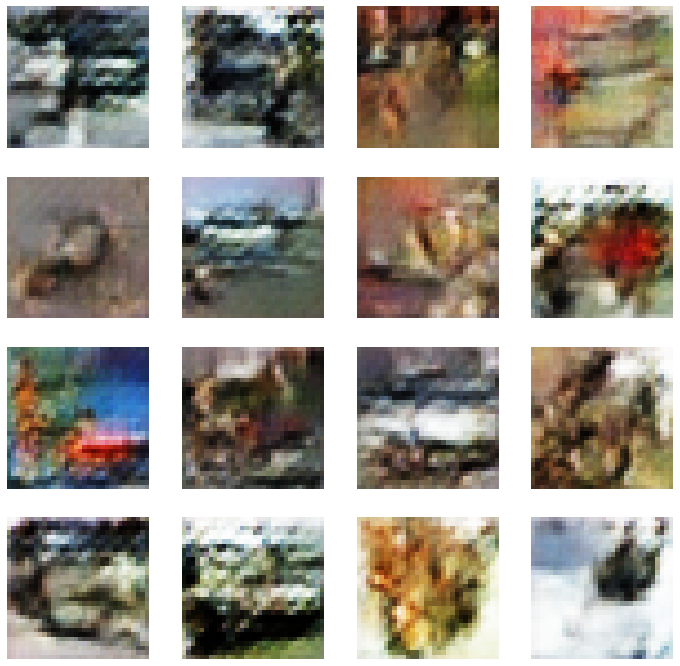

Time for training : 3274 sec


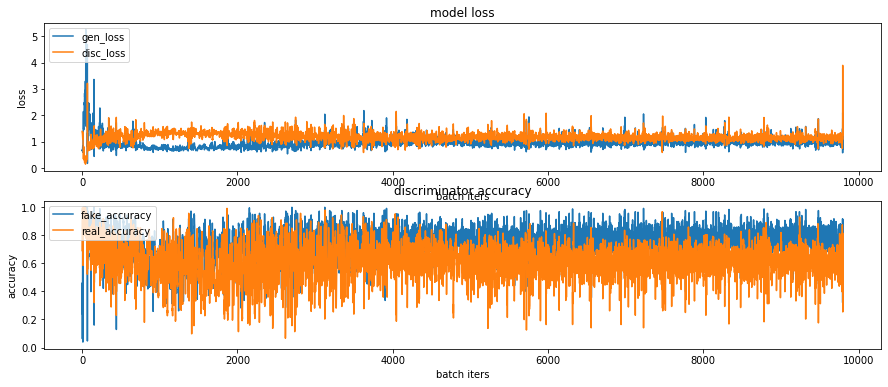

CPU times: user 54min 21s, sys: 17.1 s, total: 54min 38s
Wall time: 54min 35s


In [226]:
%%time
train(train_dataset, EPOCHS, save_every)

* Generator, discriminator에 layer를 추가하고 진행한 테스트에서 loss 값은 오히려 발산하고, accuracy 값은 fake와 real 둘다 1에 수렴하는 정반대의 결과를 확인했다. 이는 원하던 결과와 정 반대되는 방향이었기에 30 epchos 정도에서 멈추었다.
* 게다가 layer가 늘어난 만큼 parameter 수도 엄청 증가해서 학습시간이 2~3배 이상 더 걸렸기에 상당히 비효율적이라는 생각이 들었다.
* 따라서 다시 layer를 제거하였고, parameter는 그대로 둔 상태에서 epochs 50, batch_size 256 의 기본조건에서 어떻게 결과가 나오는지를 확인 해 보기로 했다.
* 결과적으로 위의 이미지에서도 확인이 가능하듯이 지금까지 해본 시도중에 가장 그럴듯한 이미지가 형성 되었다. (2, 1) 이미지는 약간 오리 같은 형상을 보이고 (3, 1) 이미지도 약간 물 위에 떠있는 오리(빨간색이 몸통)처럼 보이기도 한다. 이런 오리처럼 생긴 이미지는 맨 위에서 CIFAR10 이미지를 몇개 불러왔을 때 'index 6 번'에 해당하는 타조처럼 보이는 이미지 같은 것들이 모티브가 된 것이 아닌가 하는 생각이 든다. 그리고 (2, 2)와 (3, 3)은 둘다 유사하게 정면에서 바라본 자동차(흰색 본체와 그 위에 앞 유리)와 비슷한 형상을 보인다. 마지막으로 (4, 4)는 돌 내지는 얼음 위에 올라가있는 동물 처럼 보이기도 하는데 어떤 동물인지는 구분할 수 없다. 이렇게 몇 몇 유사하게 보이는 것들이 있지만 전체적으로 아직 이미지가 불완전하고 accuracy 값이 0.5에 수렴하지 못하고 있기에 더 테스트를 진행 해보기로 한다.
* 추가 사항으로, 조금 더 DCGAN의 여러 조건들에 대해서 찾아본 결과 adam optimizer를 사용할 때 parameter로 lr=0.0002, beta_1=0.5, beta_2=0.999 를 사용했을 때 결과가 가장 좋아서 대부분 이 값을 고정으로 사용한다고 한다. 따라서 다음 테스트에서 beta_2를 추가하여 진행할 예정이다.

#### 모델 재학습 3 - optimizer parameter 변경, batch_size, epochs 변경
- 지금까지의 결과를 토대로 가장 적합한 조건이라고 생각되는 상태에서 다시 학습을 진행 해 볼 생각이다.
1. BATCH_SIZE = 128
2. EPOCHS = 100
3. Generator, discriminator parameter 설정 완료
4. Optimizer parameter (lr, beta_1, beta_2) 설정 완료
5. Latent dimension 크기 변경 : 100 -> 128 (학습 속도가 빨라진다고 하는걸 봐서 시도해 봄)
: 테스트 결과 latent dimension을 변경해도 별 차이가 없다. 100으로 다시 설정

In [123]:
# Optimizer : beta_2 추가
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)

In [124]:
BATCH_SIZE = 128
EPOCHS = 100
# latent dimension = (100, )

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

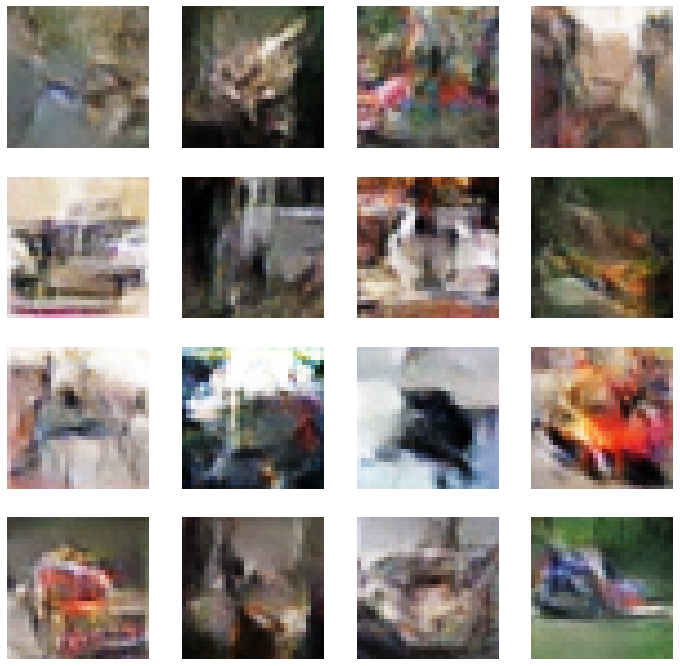

Time for training : 5274 sec


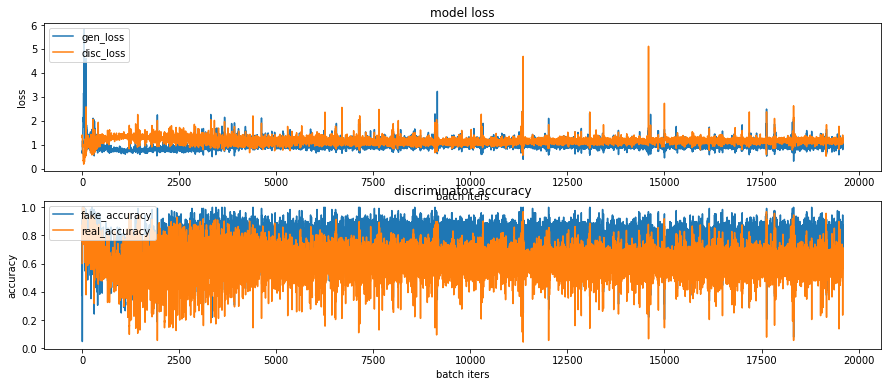

CPU times: user 1h 27min 40s, sys: 35.2 s, total: 1h 28min 15s
Wall time: 1h 27min 55s


In [125]:
%%time
train(train_dataset, EPOCHS, save_every)

* 이번 테스트에서는 그럴듯한 이미지가 딱히 만들어지지 않았다.

#### BATCH_SIZE 64, EPOCHS 50

In [157]:
BATCH_SIZE = 64
EPOCHS = 50

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

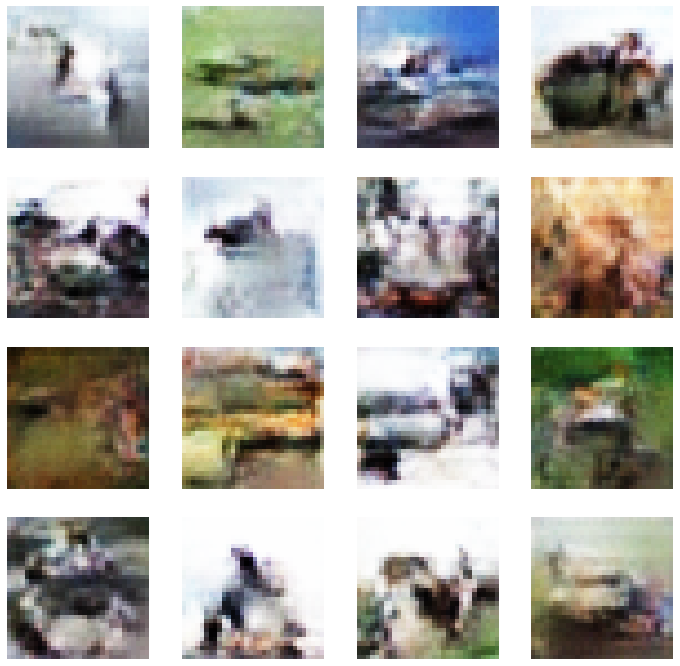

Time for training : 2147 sec


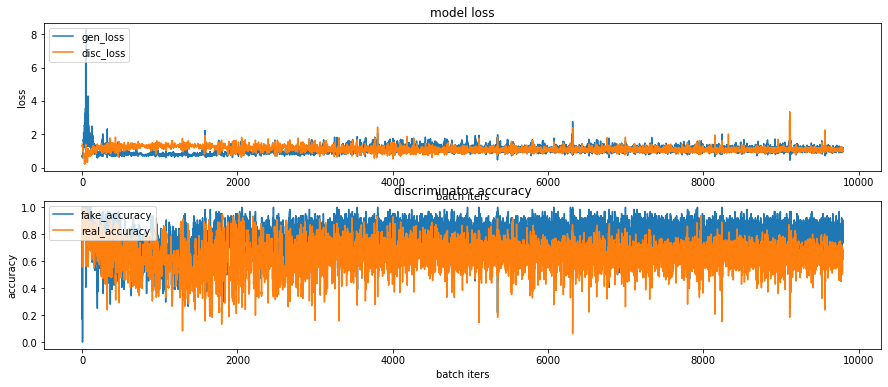

CPU times: user 35min 42s, sys: 20.5 s, total: 36min 2s
Wall time: 35min 48s


In [158]:
%%time
train(train_dataset, EPOCHS, save_every)

* 앞선 테스트에서도 이와 비슷한 이미지가 하나 있었는데, (2, 2) 이미지가 약간 얼음위에 있는 새, 내지는 어떤 동물 처럼 보이기도 하는데 명확하지 않다.
* 그리고 (3, 2)의 이미지가 약간 노란색 버스의 옆모습 처럼 보이기도 하는데 노란색이 몸통이고 바퀴 같은 동그라미가 두개 보이고 그 위쪽으로 유리가 있고 검은색 테두리가 유리의 테두리 정도로 생각된다. 물론 이 또한 명확하지는 않지만 그래도 유추할 수 있을 정도의 이미지는 만들어지는 것 같다.

#### BATCH_SIZE 256, EPOCHS 100

In [188]:
BATCH_SIZE = 256
EPOCHS = 100

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

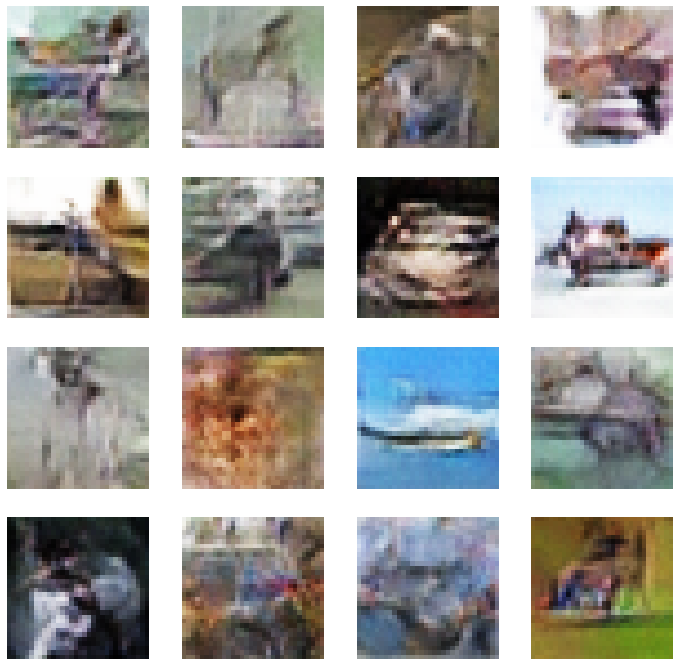

Time for training : 6885 sec


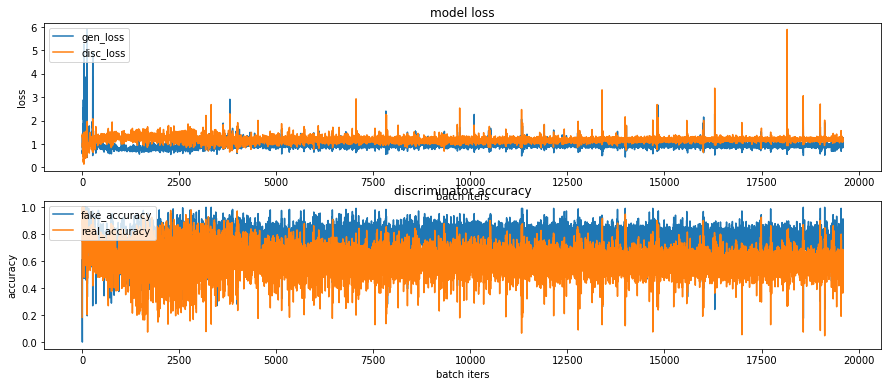

CPU times: user 1h 54min 21s, sys: 37.5 s, total: 1h 54min 58s
Wall time: 1h 54min 46s


In [189]:
%%time
train(train_dataset, EPOCHS, save_every)

* 마지막으로 시도 해본 결과 (3, 3)은 바다위의 배 같은 형상이 조금 보이고, (4, 4)는 풀밭위에 말 처럼 조금 보이긴하는데 머리쪽이 만들어지다 만 느낌이다.

### 4. 회고

* 이번 노드는 Generative Adversarial Networks (GAN) 에 대한 내용이었고, 그중에서도 Deep Convolutional Generative Adversarial Nets (DCGAN)을 다루는 방법에 대한 내용이었다.
* GAN이라는 것은 이름만 알고있는 정도였는데 이번에 자세하게 공부를 해보니 상당히 신기하고 재미가 있었다.
* 또한 그래픽 분야 뿐만아니라 거의 모든 분야에서 다양하게 사용될 수 있는 잠재력을 가진 기술이라는 생각도 들었다.
* 일단 노드의 목적은 학습된 이미지와 유사한 형태의 이미지를 생성하고, 이렇게 만들어진 이미지를 마치 원래 있는 이미지 인것 처럼 인식하도록 하는 것이었다.
* LMS의 1차원 패션이미지를 가지고 생성을 했을 때는 상당히 그럴듯한 이미지들이 만들어지는 것을 알 수 있었다. 하지만 CIFAR10의 이미지를 사용한 시도에서는 그럴듯한 이미지를 만들어 내는 것이 결코 쉽지 않았다. 이런 차이가 왜 생긴 것일까 잠깐 생각해 봤는데 아무래도 이미지 종류의 수 에서 오는 차이 때문이라는 생각이 들었다. 패션이라고 하면 주로 신발, 상의, 하의 등 정해진 몇 가지의 카테고리를 기본으로 하고 있고 디자인 또한 일정 틀에서 크게 벗어나는 것이 잘 없기 때문에 이 부분에 대해 쉽게 학습이 가능하고 따라서 유사한 이미지 또한 쉽게 만들어 낼 수 있었다고 본다. 하지만 CIFAR10 에서는 동물부터 시작해서 자동차, 배 등 정말 다양한 이미지들이 섞여있기 때문에 이를 모두를 그룹화하고 거기에 맞춘 이미지가 만들어지기는 아무래도 패션보다는 역시 힘들지 않나 하는 생각이 든다.
* 다음으로 모델에 대한 부분을 살펴보면 먼저 기본적인 틀은 그대로 두되, 가장 기본적인 batch_size 및 epochs 수치를 변경하는 것으로 성능에 변화가 나타나는지 테스트 해 보았다. 
* batch_size는 64, 128, 256을 테스트 해 보았고, epochs는 50, 100, 200을 테스트 해 보았다.
* 결론적으로 이 두가지 값을 일부 변화시키는 것으로는 큰 효과를 얻지 못했고 따라서 세세한 parameter들을 수정 해 줄 필요가 있었다.
* 먼저 generator, discriminator의 LeakyReLU 의 alpha값을 설정하고, dense의 activiation을 sigmoid로 설정하였다. 그리고 optimizer를 adam으로 사용했는데 자료들을 좀 찾아본 결과, 특히 DCGAN에서 adam을 사용할 때 이미 다른사람들이 사용한 최적의 parameter들이 존재하는 것을 알게 되었고 그와 동일하게 lr, beta_1, beta_2 값을 설정 해 주었다. 
* 그와 별개로 generator, discriminator에 layer를 추가해 보거나, latent dimension 크기를 100에서 128로 바꿔보거나, strides를 조절해보거나 하는 등 여러가지 테스트를 해보았는데 큰 효과가없거나 오히러 효율이 떨어지는 그래프를 확인해서 이 조건들은 사용하지 않는 것으로 결정하였다.
* 요약하자면, 주요 몇가지 parameter들에 대해 특정 값으로 설정을 해주고, batch_size, epochs의 다양한 조합을 시도 해 보면서 그럴듯한 이미지가 만들어 지는지 확인을 해 본 것이라 할 수 있다.
* 결과적으로, 각 만들어진 이미지에 대해 설명해 둔 것 처럼, 원숭이와 비슷한 이미지, 오리와 비슷한 이미지, 그리고 자동차와 약간 유사하게 보이는 이미지 등이 만들어졌다.
* 하지만 여전히 정확도가 상당히 떨어진다고 볼 수 있으며, 여러가지 방법을 통해 개선할 필요가 있어보인다.
* 그 중에 하나로 BinaryCrossEntropy의 parameter를 조절해서, 만들어진 이미지를 discriminator가 평가할 때 좀 더 유연하게 평가 하도록 하는 방법도 있던데 그 것 까지는 시간관계상 해볼 수가 없었다.
* 마지막으로, 앞서 말한 것 처럼 GAN 기술은 앞으로도 정말 다양한 분야에서 쓰이게 될 것이라 생각하기 때문에 개인적으로라도 계속 공부해 볼 만한 가치가 있다고 생각한다.